In [1]:
import os
import re
import cv2
import json
import array
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import OpenEXR
import Imath
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage

In [3]:
pano_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/rgb"
xyz_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/global_xyz"
instance_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/semantic"
# 选取图像
pano_list = os.listdir(pano_dir)
print(len(pano_list))
pano_name = pano_list[34]
print(pano_name)
pano_path = os.path.join(pano_dir, pano_name)
# 确定3D标注路径
xyz_name = pano_name.replace('rgb.png', 'global_xyz.exr')
xyz_path = os.path.join(xyz_dir, xyz_name)
# 确定实例分割标签路径
instance_name = pano_name.replace('rgb', 'semantic')
instance_path = os.path.join(instance_dir, instance_name)
# 确定标注文件路径
semantic_label_path = "/hpc2hdd/home/yhuang489/ylguo/PanoCode/2D-3D-Semantics/assets/semantic_labels.json"

86
camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_equirectangular_domain_rgb.png


## 功能函数

In [4]:
""" Label functions """
def load_labels( label_file ):
    """ Convenience function for loading JSON labels """
    with open( label_file ) as f:
        return json.load( f )

def parse_label( label ):
    """ Parses a label into a dict """
    res = {}
    clazz, instance_num, room_type, room_num, area_num = label.split( "_" )
    res[ 'instance_class' ] = clazz
    res[ 'instance_num' ] = int( instance_num )
    res[ 'room_type' ] = room_type
    res[ 'room_num' ] = int( room_num )
    res[ 'area_num' ] = int( area_num )
    return res

def get_index(color):
    """ Parse a color as a base-256 number and return the index """
    r, g, b = map(int, color)  # 👈 转换为 Python int 类型，避免 uint8 溢出
    return r * 256 * 256 + g * 256 + b

# 读取exr文件
def read_exr( image_fpath ):
    """ Reads an openEXR file into an RGB matrix with floats """
    f = OpenEXR.InputFile( image_fpath )
    dw = f.header()['dataWindow']
    w, h = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)    
    im = np.empty( (h, w, 3) )

    # Read in the EXR
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    channels = f.channels( ["R", "G", "B"], FLOAT )
    for i, channel in enumerate( channels ):
        im[:,:,i] = np.reshape( array.array( 'f', channel ), (h, w) )
    return im

# 可视化3D场景
def plot_xyz_pointcloud(xyz_map, step=10):
    h, w, _ = xyz_map.shape
    pts = xyz_map[::step, ::step].reshape(-1, 3)  # 降采样
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1, c=pts[:, 2], cmap='viridis')
    ax.set_title("3D Point Cloud from Global XYZ")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    plt.show()

## 首先提取这张图像中的所有实例

In [5]:
# 读取图像
pano = Image.open(pano_path)
np_pano = np.array(pano)
print(np_pano.shape)
# 读取实例分割标签
np_instance_image = np.array(Image.open(instance_path))
# 读取语义标注json文件
semantic_labels = load_labels(semantic_label_path)
semantic_nums = len(semantic_labels)
print(semantic_nums)
# 统计所有出现过的类别
clazzs = set()
for label in semantic_labels:
    label = parse_label(label)
    clazzs.add(label['instance_class'])
print(list(clazzs))
# 读取3D标注并解析
xyz_image = read_exr(xyz_path)
print(xyz_image.shape)

(2048, 4096, 4)
9816
['wall', 'sofa', 'column', 'floor', 'bookcase', 'clutter', 'chair', '<UNK>', 'beam', 'table', 'ceiling', 'board', 'window', 'door']
(2048, 4096, 3)


In [6]:
h, w, _ = np_pano.shape
instance_index = np.zeros([h, w])
for i in range(h):
    for j in range(w):
        instance_index[i, j] = get_index(np_instance_image[i, j])
instance_ids = np.unique(instance_index)
# 获取图像中所有实例在json文件中的index
instance_ids = instance_ids[instance_ids < semantic_nums]
instance_info = []
for iid in instance_ids:
    label = parse_label(semantic_labels[int(iid)])
    cur_info = dict()
    cur_info['class_name'] = label['instance_class']
    cur_info['mask'] = (instance_index == iid)
    cur_info['points'] = xyz_image[cur_info['mask']]
    instance_info.append(cur_info)
print(len(instance_info))

73


## 可视化检查所有实例

In [ ]:
check_index = 0
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axis[0].imshow(np_pano)
axis[0].axis('off')
axis[1].imshow(instance_info[check_index]['mask'])
axis[1].axis('off')
cy, cx = ndimage.center_of_mass(instance_info[check_index]['mask'])
axis[1].text(cx+100, cy+100, str(instance_info[check_index]['class_name']),
     fontsize=10, color='white', ha='center', va='center',
     bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.5))
plt.show()

## 可视化数据生成结果

In [12]:
data_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoCode/SpatialR360_DG/output/area3"
data_list = os.listdir(data_dir)
data_name = data_list[4]
data_path = os.path.join(data_dir, data_name)
with open(data_path, 'r') as f:
    data = json.load(f)

You are a language model tasked with generating spatial reasoning questions based on a panoramic scene with (h, w)=(2048, 4096).

Your task is to generate complex spatial reasoning tasks using given object information, such as:
- An object that satisfies multiple spatial constraints at once.
- An object positioned between two others.
- Comparison tasks involving sorting or ranking (by distance, height, etc.)
- An object spatial position related to other objects.
The data format I need is a question, a chain of reasoning and the final answer. The format is shown below:
    Question:
    xxx
    Reasoning Chain:
    xxx
    Final Answer:
    xxx
Use natural and diverse language. Do not include coordinate values or measurements in your output.


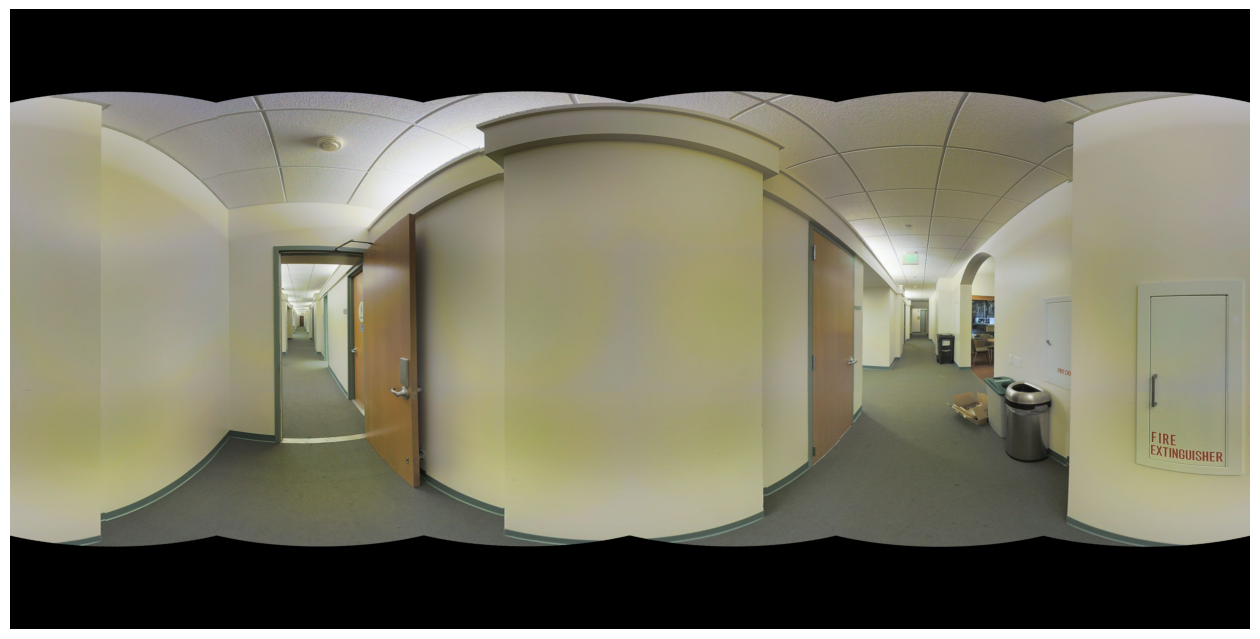

In [13]:
image_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/rgb"
image_name = data["image_id"]+'.png'
np_image = np.array(Image.open(os.path.join(image_dir, image_name)))
print(data['prompt'])
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
axis.imshow(np_image)
axis.axis('off')
plt.show()

In [14]:
print(data['reasoning'][3])

{'question': 'Suppose you are walking down the hallway from the large, rounded column positioned prominently in the middle of the hallway toward the tall, black trash bin situated further down and against the wall. Which major doorway do you pass before reaching the trash bin?', 'reasoning_chain': 'Starting at the large, rounded column in the middle of the hallway, you head down the corridor toward the end where the tall, black trash bin is located. Along this path, you would encounter the wooden door that stands partially open along the hallway, as it is situated between the column and the trash bin. This door serves as a noticeable entryway before reaching the end of the hallway where the trash bin stands.', 'final_answer': 'You pass the wooden door that stands partially open along the hallway before reaching the tall, black trash bin.'}
